In [1]:
import os, sys
import random
import numpy as np 
import pandas as pd

from PIL import Image
from PIL import Image

from datetime import datetime
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T

import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
batch_size = 64

In [3]:
path_data = '../input/recursion-cellular-image-classification/'
trnalldf = pd.read_csv(os.path.join(path_data, 'train.csv'))
tstdf = pd.read_csv(os.path.join(path_data, 'test.csv'))
statsdf = pd.read_csv(os.path.join(path_data, 'pixel_stats.csv'))

In [4]:
trnalldf.iloc[0]

id_code       HEPG2-01_1_B03
experiment          HEPG2-01
plate                      1
well                     B03
sirna              sirna_250
Name: 0, dtype: object

In [5]:
# lets look at the samples per per experiments
tstdf.experiment.value_counts().sort_index()

HEPG2-08    1107
HEPG2-09    1108
HEPG2-10    1108
HEPG2-11    1106
HUVEC-17    1108
HUVEC-18    1108
HUVEC-19    1108
HUVEC-20    1108
HUVEC-21    1108
HUVEC-22    1108
HUVEC-23    1099
HUVEC-24    1100
RPE-08      1108
RPE-09      1108
RPE-10      1108
RPE-11      1094
U2OS-04     1108
U2OS-05     1097
Name: experiment, dtype: int64

In [6]:
# Lets take the first 3 experiments as train, and the next 4 as val
valdf = trnalldf[trnalldf.experiment.str.contains('01')]
trndf = trnalldf[trnalldf.experiment.str.contains('02|03|04|05|06|07')]

In [7]:
print('Train frame shape : rows {} cols {}'.format(*trndf.shape))
print('Val frame shape : rows {} cols {}'.format(*valdf.shape))
print('Test frame shape : rows {} cols {}'.format(*tstdf.shape))

Train frame shape : rows 22153 cols 5
Val frame shape : rows 4430 cols 5
Test frame shape : rows 19899 cols 4


In [8]:
statsdf.iloc[0]

id_code       HEPG2_01_1_B02_1
experiment            HEPG2-01
plate                        1
well                       B02
site                         1
channel                      1
mean                 71.063782
std                   43.14624
median                    67.0
min                          7
max                        255
Name: 0, dtype: object

In [9]:
meanexpdf = statsdf.groupby(['experiment', 'channel'])['mean'].mean().unstack()
stdexpdf = statsdf.groupby(['experiment', 'channel'])['mean'].mean().unstack()
meanexpdf[meanexpdf.index.str.contains('01|02')]

channel,1,2,3,4,5,6
experiment,,,,,,
HEPG2-01,37.947925,26.399949,34.723836,40.014089,43.965592,30.804353
HEPG2-02,33.405073,27.128854,29.582297,46.010937,32.501942,31.144117
HUVEC-01,4.123238,19.956227,10.233502,10.657920,2.326737,12.136189
HUVEC-02,4.448384,20.802760,8.897859,10.869585,2.442969,11.343739
RPE-01,3.618764,10.956121,16.646254,7.829697,3.690766,13.503024
RPE-02,2.978969,8.812340,14.565686,6.347397,3.799188,12.526606
U2OS-01,7.537577,10.093597,10.044440,7.385857,3.014662,13.574783
U2OS-02,11.160868,12.521636,12.274936,10.068334,3.290966,16.674154


In [10]:
# We can see large differences by  
meanexpdf.loc['HEPG2-01'].values

array([37.94792521, 26.39994873, 34.72383564, 40.0140892 , 43.96559181,
       30.80435258])

**some augmentations from Albumentations **

In [12]:
from albumentations import (Cutout, Compose, Normalize, RandomRotate90, HorizontalFlip,
                           VerticalFlip, ShiftScaleRotate, Transpose, OneOf, IAAAdditiveGaussianNoise,
                           GaussNoise, RandomGamma, RandomContrast, RandomBrightness, HueSaturationValue,
                           RandomCrop, Lambda, NoOp, CenterCrop, Resize)

In [13]:
def aug(p=1.):
    return Compose([
        RandomRotate90(),
        HorizontalFlip(),
        VerticalFlip(),
        Transpose(),
        NoOp(),
    ], p=p)

**Data loader - we make a class and use torch loader******

In [14]:
class ImagesDS(D.Dataset):
    def __init__(self, df, img_dir, size = 256, mode='train', meandf = meanexpdf, stddf = stdexpdf, channels=[1,2,3,4,5,6]):
        
        self.records = df.to_records(index=False)
        self.channels = channels
        self.site = random.randint(1,2) # load a random site from each well.
        self.mode = mode
        self.meandf = meanexpdf
        self.stddf = stdexpdf
        self.img_dir = img_dir
        self.len = df.shape[0]
        self.size = size
        self.augtransform = aug()
        
    @staticmethod
    def _load_img_as_tensor(file_name, size):
        with Image.open(file_name) as img:
            img = img.resize((size, size), resample=Image.BICUBIC)
            return img
        
    @staticmethod
    def torch_augment(img, transform, mean_, sd_):
        img = img.astype(np.float32)
        img = transform(image = img)['image']
        img = torch.from_numpy(np.moveaxis(img, -1, 0).astype(np.float32))
        img = T.Normalize([*list(mean_)], [*list(sd_)])(img)
        return img  

    def _get_img_path(self, index, channel):
        experiment, well, plate = self.records[index].experiment, self.records[index].well, self.records[index].plate
        return '/'.join([self.img_dir,self.mode,experiment,f'Plate{plate}',f'{well}_s{self.site}_w{channel}.png'])
        
    def __getitem__(self, index):
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        
        # Normalise values
        meanvals = self.meandf.loc[self.records[index].experiment].values
        stdvals = self.stddf.loc[self.records[index].experiment].values
        
        # Load image
        img = np.stack([self._load_img_as_tensor(img_path, self.size) for (img_path, m, s) in zip(paths, meanvals, stdvals)], -1)
        img = self.torch_augment(img, self.augtransform, meanvals, stdvals)      
        
        if self.mode == 'train':
            return img, self.records[index].sirna
        else:
            return img, self.records[index].id_code

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [15]:
trnloader = D.DataLoader(ImagesDS(trndf, path_data, mode='train'), batch_size=batch_size, shuffle=True, num_workers=4)
valloader = D.DataLoader(ImagesDS(valdf, path_data, mode='train'), batch_size=batch_size*2, shuffle=False, num_workers=4)
tstloader = D.DataLoader(ImagesDS(tstdf, path_data, mode='test'), batch_size=batch_size*2, shuffle=False, num_workers=4)

In [20]:
X,y = next(iter(trnloader))

In [21]:
X.mean(), X.std()

(tensor(0.0353), tensor(1.0293))

In [22]:
print('Batch Shape : {}'.format(X.shape))
#print('Label Shape : {}'.format(y.shape))

Batch Shape : torch.Size([64, 6, 256, 256])


In [23]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=1000, num_channels=6):
        super().__init__()
        preloaded = torchvision.models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x, emb=False):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        if emb:
            return out
        out = self.classifier(out)
        return out

In [26]:
import re

# Extract numeric part from the 'sirna' column
trndf['sirna_numeric'] = trndf['sirna'].apply(lambda x: int(re.search(r'\d+', str(x)).group()))

# Calculate the maximum numeric value
max_sirna = trndf['sirna_numeric'].max()

# Create the DenseNet model
model = DenseNet(num_classes=max_sirna + 1, num_channels=6)
model


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 215MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

In [27]:
dir(model)[-10:]

['set_extra_state',
 'share_memory',
 'state_dict',
 'to',
 'to_empty',
 'train',
 'training',
 'type',
 'xpu',
 'zero_grad']

In [28]:
# Look at the first 10 layers
[(n, w.shape) for t, (n,w) in enumerate(model.named_parameters()) if t <10]

[('features.conv0.weight', torch.Size([64, 6, 7, 7])),
 ('features.conv0.bias', torch.Size([64])),
 ('features.norm0.weight', torch.Size([64])),
 ('features.norm0.bias', torch.Size([64])),
 ('features.denseblock1.denselayer1.norm1.weight', torch.Size([64])),
 ('features.denseblock1.denselayer1.norm1.bias', torch.Size([64])),
 ('features.denseblock1.denselayer1.conv1.weight',
  torch.Size([128, 64, 1, 1])),
 ('features.denseblock1.denselayer1.norm2.weight', torch.Size([128])),
 ('features.denseblock1.denselayer1.norm2.bias', torch.Size([128])),
 ('features.denseblock1.denselayer1.conv2.weight',
  torch.Size([32, 128, 3, 3]))]

In [29]:
model.features.denseblock2.denselayer10.conv2.weight[:1]

tensor([[[[-0.0087, -0.0077,  0.0043],
          [-0.0290,  0.0142, -0.0136],
          [ 0.0017, -0.0084,  0.0028]],

         [[-0.0135,  0.0081, -0.0076],
          [-0.0317, -0.0220, -0.0251],
          [-0.0080,  0.0146,  0.0180]],

         [[-0.0520, -0.0433, -0.0436],
          [-0.0380, -0.0208, -0.0315],
          [-0.0388, -0.0245, -0.0421]],

         ...,

         [[ 0.0034,  0.0164,  0.0061],
          [-0.0126, -0.0425, -0.0282],
          [ 0.0036, -0.0190, -0.0064]],

         [[-0.0082, -0.0288, -0.0099],
          [-0.0103,  0.0147,  0.0059],
          [-0.0264, -0.0109, -0.0458]],

         [[ 0.0127, -0.0235,  0.0074],
          [ 0.0263, -0.0375,  0.0063],
          [-0.0158, -0.0003, -0.0040]]]], grad_fn=<SliceBackward0>)

**Mixed Precision Training**
We saw apex in homework 6. This allows certain parts of the network to be stored in FP32 (32-bit floating point) and other parts to be stored in FP16 With a few small code changes we can half runtime... essential in the large networks outperforming today.

In [31]:
!pip install apex

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.8/709.8 kB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3

In [34]:
!pip install -v /path/to/NVIDIA-apex.whl


Using pip 23.1.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
ERROR: NVIDIA-apex.whl is not a valid wheel filename.


In [35]:
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/*/*/NVIDIA-apex*


Using pip 23.1.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
ERROR: Invalid requirement: '../input/*/*/NVIDIA-apex*'
Hint: It looks like a path. File '../input/*/*/NVIDIA-apex*' does not exist.


In [37]:
!pip install --upgrade apex
!pip install --upgrade pyramid


In [38]:
%%capture
# install NVIDIA Apex if needed to support mixed precision training
use_amp = True
if use_amp:
    try:
        from apex import amp
    except ImportError:
        !pip install  -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/*/*/NVIDIA-apex*
        from apex import amp

ImportError: cannot import name 'UnencryptedCookieSessionFactoryConfig' from 'pyramid.session' (unknown location)

In [42]:
!pip uninstall apex -y
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex


Found existing installation: apex 0.9.10.dev0
Uninstalling apex-0.9.10.dev0:
  Successfully uninstalled apex-0.9.10.dev0
Using pip 23.1.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
DEPRECATION: --build-option and --global-option are deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11859
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-qbqmq011/apex.egg-info
  writing /tmp/pip-pip-egg-info-qbqmq011/apex.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-qbqmq011/apex.egg-info/dependency_links.txt
  writing entry points to /tmp/pip-pip-egg-info-qbqmq011/apex.egg-info/entry_points.txt
  writing requirements to /tmp/pip-pip-egg-info-qbqmq011/apex.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-qbqmq011/apex.egg-info/top_level.txt
  writing manifest file '/tmp/pi

In [45]:
!pip install apex

  Using cached apex-0.9.10.dev0-py3-none-any.whl


In [46]:
import imp

class ImportChecker(object):
    def __init__(self, *args):
        self.module_names = args
 
    def find_module(self, fullname, path=None):
        if fullname in self.module_names:
            self.path = path
            return self
        return None
 
    def load_module(self, name):
        if name in sys.modules:
            return sys.modules[name]
        try:
            module_info = imp.find_module(name, self.path)
            module = imp.load_module(name, *module_info)
            sys.modules[name] = module
            return module
        except (ImportError, ModuleNotFoundError):
            module = False
            sys.modules[name] = module
            return module
 
import sys

sys.meta_path = [ImportChecker('apex')] + sys.meta_path

import apex
print(apex)

False


In [61]:
!pip install -v --disable-pip-version-check --no-cache-dir --no-build-isolation --config-settings "--build-option=--cpp_ext" --config-settings "--build-option=--cuda_ext" ./
# otherwise
!pip install -v --disable-pip-version-check --no-cache-dir --no-build-isolation --global-option="--cpp_ext" --global-option="--cuda_ext" ./


Using pip 23.1.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
Processing /kaggle/working/apex
  Running command Preparing metadata (pyproject.toml)


  torch.__version__  = 2.0.0


  running dist_info
  creating /tmp/pip-modern-metadata-rlvxiz4s/apex.egg-info
  writing /tmp/pip-modern-metadata-rlvxiz4s/apex.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-modern-metadata-rlvxiz4s/apex.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-modern-metadata-rlvxiz4s/apex.egg-info/requires.txt
  writing top-level names to /tmp/pip-modern-metadata-rlvxiz4s/apex.egg-info/top_level.txt
  writing manifest file '/tmp/pip-modern-metadata-rlvxiz4s/apex.egg-info/SOURCES.txt'
  adding license file 'LICENSE'
  writing manifest file '/tmp/pip-modern-metadata-rlvxiz4s/apex.egg-info/SOURCES.txt'
  creating '/tmp/pip-modern-metadata-rlvxiz4s/apex.dist-info'
  Preparing metadata (pyproject.toml) ... done
  Running command Building wheel for apex (pyproject.toml)


  to

In [63]:
cd ..


/kaggle/working


In [74]:
import re

try:
    from apex import amp
except ImportError:
    import sys
    !{sys.executable} -m pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
    !{sys.executable} -m pip install apex

# Rest of your code
numeric_values = trndf.sirna.apply(lambda x: re.findall(r'\d+', str(x)))


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch==1.9.0+cu111


In [76]:
import re
from apex import amp

# Extract numeric values from the 'trndf.sirna' column using regex
numeric_values = trndf.sirna.apply(lambda x: re.findall(r'\d+', str(x)))
trndf['numeric_sirna'] = numeric_values.apply(lambda x: int(x[0]) if len(x) > 0 else None)

# Filter out rows with non-numeric values
trndf_filtered = trndf[trndf.numeric_sirna.notnull()]

# Calculate the maximum value
max_sirna = int(trndf_filtered.numeric_sirna.max())

# Create the DenseNet model
model = DenseNet(num_classes=max_sirna + 1, num_channels=6)
model.to(device)

# Rest of your code...

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", keep_batchnorm_fp32=False, loss_scale="dynamic")


ImportError: cannot import name 'amp' from '<unknown module name>' (unknown location)

In [77]:
# One cycle policy https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy
optimizer.param_groups[0]['lr'] = .001 
onecycdf = trnalldf
onecycleloader = D.DataLoader(ImagesDS(onecycdf, path_data, mode='train'), batch_size=batch_size, shuffle=True, num_workers=8)
print('Total Step Count : {}'.format(len(onecycleloader)))



Total Step Count : 571


<Axes: title={'center': 'LR per step'}>

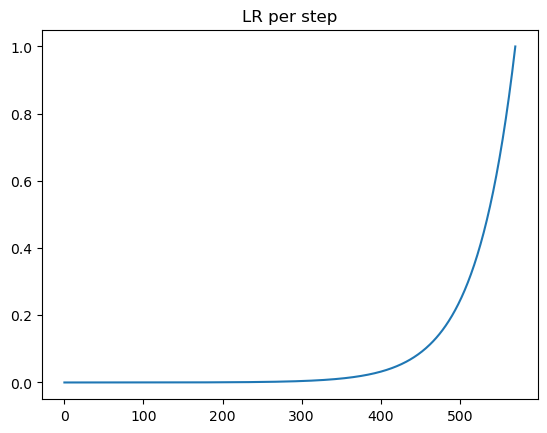

In [78]:
import math
init_value = 1e-5
final_value=1.
beta = 0.98
avg_loss = 0.
batch_num = 0
numsteps = len(onecycleloader)-1
mult = (final_value / init_value) ** (1/numsteps )
lrvals = pd.Series([init_value*(mult**i) for i in  range(numsteps+ 1)])
lrvals.plot(title='LR per step')

In [81]:
lossls = []
optimizer.param_groups[0]['lr'] = init_value
for t, (x, y) in enumerate(onecycleloader): 
    optimizer.zero_grad()
    x = x.to(device)#.half()
    y = y.cuda()
    xgrad = torch.autograd.Variable(x, requires_grad=True)#.half()
    ygrad = torch.autograd.Variable(y)
    out = model(xgrad)
    loss = criterion(out, ygrad)
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()
    optimizer.step()
    optimizer.param_groups[0]['lr'] = init_value*(mult**t)
    
    ######One Cycle Policy##########>
    #Compute the smoothed loss
    batch_num += 1
    avg_loss = beta * avg_loss + (1-beta) *loss.item()
    smoothed_loss = avg_loss / (1 - beta**batch_num)
    lossls.append(smoothed_loss)

    if t%20==0:
        print('Step {} lr {:.6f} smoothed loss {:.5f} time {}'.format(t, init_value*(mult**t), smoothed_loss, datetime.now()))
    del loss, out, y, x# , target

AttributeError: 'tuple' object has no attribute 'cpu'